## 도심과 지방이 공존하는 도시 춘천

춘천시는 도시지역과 지방지역이 공존하는 도시입니다.

서울과 다르게 지역별로 분포하는 연령층, 인구수, 인프라정도 (시설물수) 들이 각각 다르기에,

모든 지역을 균일하게 도입을 하기에는 춘천시 입장에서 예산적으로 무리가 있을것으로 판단했습니다.

따라서 춘천시의 지역을 군집으로 나눠 비슷한 성격끼리 분류하고

타봄을 가장 필요로하고 활성화가 잘 될것 같은 군집에 속한 지역을 우선적으로 선정하고자 합니다.

#### kmeans-clustering을 통한 우선 도입 지역 선정

- 필요 패키지 불러오기
- 데이터 불러오기
- 데이터 전처리
    - 변수간 상관관계 확인
    - 데이터 척도 통일 (minmaxscale)
    - 주성분 분석(pca)
    - kmeans-clustering
- 데이터 시각화

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift, estimate_bandwidth

# grid search
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.metrics.cluster import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import *

In [2]:
chuncheon = pd.read_csv("/Users/nayoungmin/Desktop/major/2023-1/DataScience_basic/project/춘천시 데이터.csv")

chuncheon["10~30대"] = chuncheon['10세 ~ 19세']+chuncheon['20세 ~ 29세']+chuncheon['30세 ~ 39세']
chuncheon['시설물'] =chuncheon['학교 수']+ chuncheon['금융기관']+chuncheon['의료기관(병원수)']+ chuncheon['공공체육시설']
local = chuncheon[["행정구역",'인구밀도 2019', '면적 (㎢) 2019', '10~30대','버스정류장 수','시설물']]

local= local.set_index(local['행정구역'])
local= local.drop(['행정구역'],axis = 1)
local

,인구밀도 2019,면적 (㎢) 2019,10~30대,버스정류장 수,시설물
행정구역,,,,,
신북읍,140,57.20,1649,105,13
동면,148,134.27,6485,104,23
동산면,19,80.79,260,75,12
신동면,54,48.15,531,61,6
동내면,484,36.56,5805,69,19
남면,15,73.25,124,62,2
남산면,29,124.01,555,103,9
서면,28,141.50,562,132,13
사북면,17,152.45,384,74,7


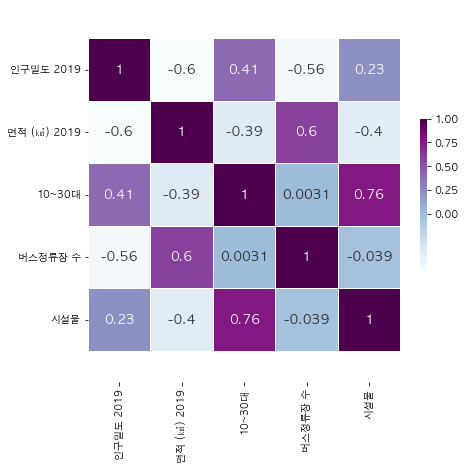

In [3]:
# 변수간 상관관계 확인
f, ax = plt.subplots(figsize=(7, 7))
g = sns.heatmap(local.corr(), annot=True, square=True, 
            linewidths=0.5,
            cbar_kws = {'shrink': .4,
                        'ticks' : [0 , 0.25, 0.5, 0.75 , 1]}, 
            annot_kws = {'size': 13},cmap='BuPu')
bottom, top = g.get_ylim() # heatmap plot이 잘리는 것 방지하기 위한 방법
g.set_ylim(bottom+0.5, top-0.5)
plt.show()

In [4]:
# 후평동, 효자동 통일
hpd= local.loc[['후평1동','후평2동','후평3동']]
hjd= local.loc[['효자1동','효자2동','효자3동']]
hpd = pd.DataFrame(hpd.sum(axis=0))
hjd = pd.DataFrame(hjd.sum(axis=0))
hpd = hpd.transpose()
hjd = hjd.transpose()
hpd = hpd.set_index(pd.Index(['후평동']))
hjd = hjd.set_index(pd.Index(['효자동']))

local2 = pd.concat([local, hjd,hpd])
local2 = local2.drop(['효자1동','효자2동','효자3동','후평1동','후평2동','후평3동'],axis =0)
local2

,인구밀도 2019,면적 (㎢) 2019,10~30대,버스정류장 수,시설물
신북읍,140.0,57.20,1649.0,105.0,13.0
동면,148.0,134.27,6485.0,104.0,23.0
동산면,19.0,80.79,260.0,75.0,12.0
신동면,54.0,48.15,531.0,61.0,6.0
동내면,484.0,36.56,5805.0,69.0,19.0
남면,15.0,73.25,124.0,62.0,2.0
남산면,29.0,124.01,555.0,103.0,9.0
서면,28.0,141.50,562.0,132.0,13.0
사북면,17.0,152.45,384.0,74.0,7.0
북산면,4.0,214.95,81.0,28.0,1.0


In [5]:
# 데이터의 척도 통일
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(local2)
df = pd.DataFrame(x_scaled,columns = local2.columns)
df = df.set_index(local2.index)
df

,인구밀도 2019,면적 (㎢) 2019,10~30대,버스정류장 수,시설물
신북읍,0.003004,0.265014,0.091482,0.784,0.142857
동면,0.003180,0.624097,0.373629,0.776,0.261905
동산면,0.000331,0.374924,0.010443,0.544,0.130952
신동면,0.001104,0.222849,0.026254,0.432,0.059524
동내면,0.010601,0.168849,0.333956,0.496,0.214286
남면,0.000243,0.339794,0.002509,0.440,0.011905
남산면,0.000552,0.576294,0.027655,0.768,0.095238
서면,0.000530,0.657783,0.028063,1.000,0.142857
사북면,0.000287,0.708801,0.017678,0.536,0.071429
북산면,0.000000,1.000000,0.000000,0.168,0.000000


In [10]:
# 차원축소
pca = PCA(n_components=2)
pca_dat = pca.fit_transform(df)
print(pca_dat.shape)
print(pca.explained_variance_ratio_)#2개의 변수로 5가지 변수의 80%를 설명

(21, 2)
[0.57658395 0.24232874]


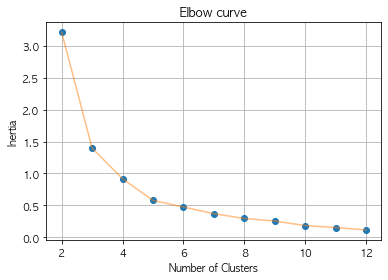

In [11]:
# 군집을 통한 지역별 성격 나누기
# 사용자 정의 함수
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
    
    plt.grid(True)
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow curve')
    
n_clusters = range(2,13)
change_n_clusters(n_clusters, pca_dat)

In [15]:
#최적의 군집 수 = 3개
best_k = 3

km = KMeans(n_clusters=best_k, init='k-means++', random_state = 20)
cluster = km.fit(pca_dat)
cluster_id = pd.DataFrame(cluster.labels_)


pca_dat2= pd.DataFrame(pca_dat)
d1 = pd.concat([pca_dat2, cluster_id], axis=1)
d1.columns = ['pc1', 'pc2', "cluster"]
print(d1)
print(d1['cluster'].value_counts())

         pc1       pc2  cluster
0  -0.298113 -0.190550        0
1  -0.243621 -0.472941        0
2  -0.368897 -0.018941        0
3  -0.306791  0.144884        0
4  -0.027105 -0.023930        1
5  -0.403544  0.103133        0
6  -0.508709 -0.286303        0
7  -0.557869 -0.514440        0
8  -0.555803 -0.155665        0
9  -0.688318  0.021634        0
10  0.187777  0.406345        1
11 -0.036183  0.551977        1
12  0.126798  0.492359        1
13  0.059122  0.421217        1
14  0.002717  0.351006        1
15  0.769119 -0.185182        2
16  0.821802 -0.204102        2
17  0.365619 -0.152666        2
18  0.193395  0.050246        1
19  0.443837  0.068441        2
20  1.024768 -0.406522        2
0    9
1    7
2    5
Name: cluster, dtype: int64


In [16]:
local_clu = local2
local_clu['cluster']= np.array(cluster_id)
local_clu

,인구밀도 2019,면적 (㎢) 2019,10~30대,버스정류장 수,시설물,cluster
신북읍,140.0,57.20,1649.0,105.0,13.0,0
동면,148.0,134.27,6485.0,104.0,23.0,0
동산면,19.0,80.79,260.0,75.0,12.0,0
신동면,54.0,48.15,531.0,61.0,6.0,0
동내면,484.0,36.56,5805.0,69.0,19.0,1
남면,15.0,73.25,124.0,62.0,2.0,0
남산면,29.0,124.01,555.0,103.0,9.0,0
서면,28.0,141.50,562.0,132.0,13.0,0
사북면,17.0,152.45,384.0,74.0,7.0,0
북산면,4.0,214.95,81.0,28.0,1.0,0


In [17]:
local_clu_0 = local_clu.query('cluster == 0')
local_clu_1 = local_clu.query('cluster == 1')
local_clu_2 = local_clu.query('cluster == 2')

# 같은 군집에 속한 지역끼리 비슷한 성격을 띔
print('\n============================== 0번 군집==============================\n')
print(local_clu_0)
print('\n============================== 1번 군집==============================\n')
print(local_clu_1)
print('\n============================== 2번 군집==============================\n')
print(local_clu_2)


============================== 0번 군집==============================

     인구밀도 2019  면적 (㎢) 2019  10~30대  버스정류장 수   시설물  cluster
신북읍      140.0        57.20  1649.0    105.0  13.0        0
동면       148.0       134.27  6485.0    104.0  23.0        0
동산면       19.0        80.79   260.0     75.0  12.0        0
신동면       54.0        48.15   531.0     61.0   6.0        0
남면        15.0        73.25   124.0     62.0   2.0        0
남산면       29.0       124.01   555.0    103.0   9.0        0
서면        28.0       141.50   562.0    132.0  13.0        0
사북면       17.0       152.45   384.0     74.0   7.0        0
북산면        4.0       214.95    81.0     28.0   1.0        0

============================== 1번 군집==============================

      인구밀도 2019  면적 (㎢) 2019  10~30대  버스정류장 수   시설물  cluster
동내면       484.0        36.56  5805.0     69.0  19.0        1
소양동      8592.0         0.50  2943.0     15.0  35.0        1
교동       9518.0         0.32  1553.0      7.0   4.0        1
조운동      4601.0   

(-1.1154732732949657,
 1.100723395828777,
 -1.1023880669738688,
 1.1501559068205867)

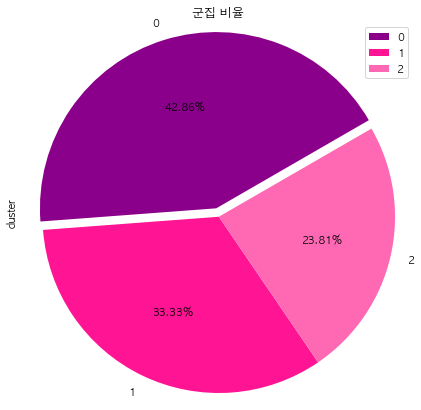

In [18]:
# 각 군집의 비율 확인
local_clu['cluster'] = km.labels_

plt.figure(figsize=(6,6))
color = ['darkmagenta', 'deeppink', 'hotpink']
local_clu.cluster.value_counts().plot.pie(autopct='%.2f%%', figsize=(7,7),
                                startangle=30, legend='all', explode=(0.05,0,0), colors = color)
plt.title('군집 비율')
plt.axis('equal')

cluster
0       50.444444
1     4919.714286
2    18151.200000
Name: 인구밀도 2019, dtype: float64
cluster
0    114.063333
1      8.622857
2      5.890000
Name: 면적 (㎢) 2019, dtype: float64
cluster
0     1181.222222
1     3544.142857
2    12543.000000
Name: 10~30대, dtype: float64
cluster
0    82.666667
1    28.571429
2    61.200000
Name: 버스정류장 수, dtype: float64
cluster
0     9.555556
1    23.571429
2    61.200000
Name: 시설물, dtype: float64
cluster
0    0.0
1    1.0
2    2.0
Name: cluster, dtype: float64


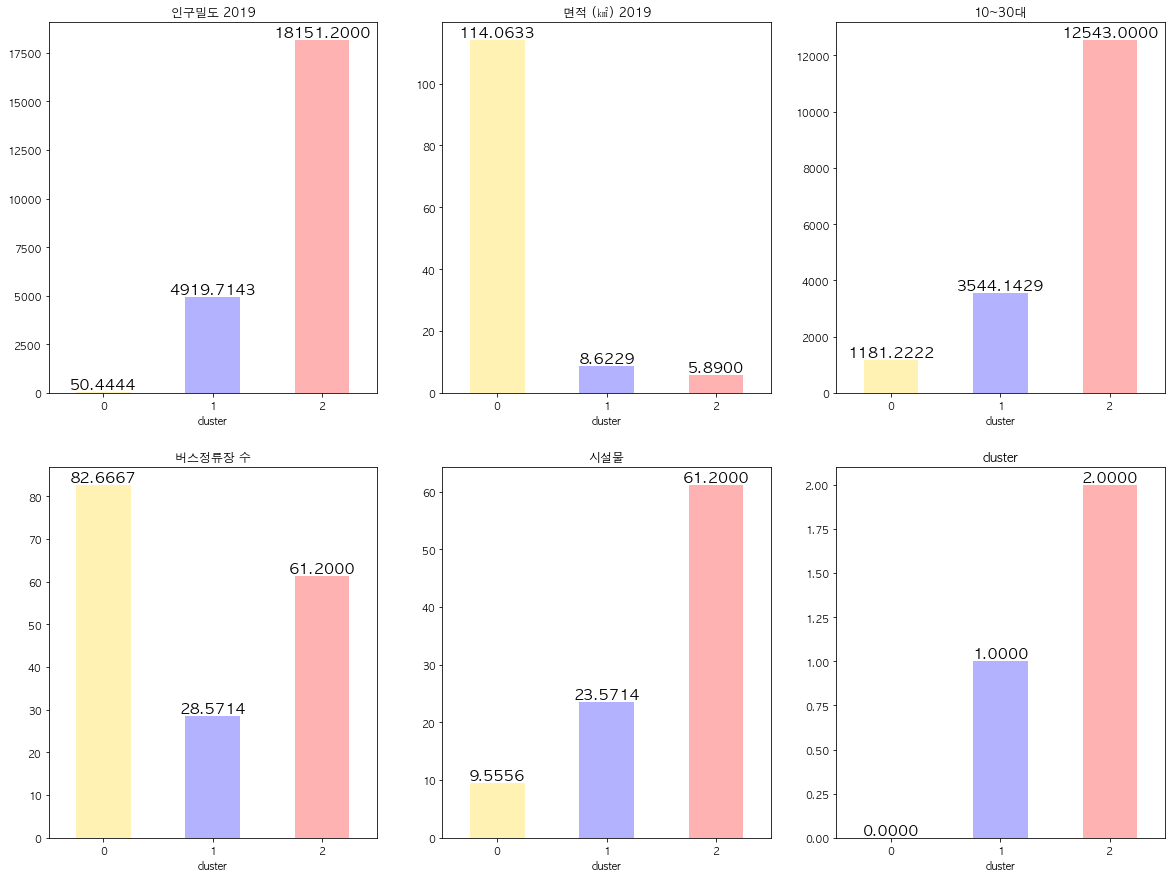

In [19]:
# 군집별 막대그래프 UDF 생성

def make_fig(column):
    local_clu.groupby('cluster')[column].mean().plot(kind = 'bar',color = ['gold', 'b', '#FF0000'], alpha = 0.3)
    print(local_clu.groupby('cluster')[column].mean())
    for k in range(len(local_clu.groupby('cluster')[column].mean().values)):
        height = local_clu.groupby('cluster')[column].mean().values[k]
        plt.text(local_clu.groupby('cluster')[column].mean().index[k], height, '%.4f' % height, size=15, ha='center', va='bottom')
    plt.xticks(rotation=360)
    plt.title('{}'.format(column))
    # plt.savefig(column+'.png', bbox_inches="tight");

# 그래프 크기 설정
plt.figure(figsize=(20,15))

# 시각화
for i in range(0, np.shape(local_clu)[1]) :
    #print(i)
    
    plt.subplot(2, 3, i+1)
    make_fig(local_clu.columns[i])


#### 2번 군집에 속한 행정동을 우선 입지 지역으로 선정
 - 석사동,퇴계동,강남동,효자동,후평동
 
따라서 2번 군집에 해당하는 도시들 중 10~30대 분포가 높은

춘천시 관광지 및 상권지역에 자전거 입지 선정을 하는 것을 진행할 예정입니다.